# Setup

In [1]:
base_path = "../"
src_path = base_path+"src/"
exec(open(src_path+"loader.py").read()) # read loader
exec(open(src_path+"loader_transformer.py").read()) # read loader

2022-10-03 14:30:14.167397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64/mysql-workbench:/usr/lib64/mysql-workbench
2022-10-03 14:30:14.167435: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Prepare Data

In [2]:
def loadDataset(name,level="stroke"):
  file_list = data_path + name +'_train.csv', data_path + name +'_val.csv', data_path + name +'_test.csv'
  train,val,test = getList(file_list)

  print("Preparing Train Data...")
  train_bar = tqdm( train )
  for file_name in train_bar:
    train_bar.set_postfix({'file': file_name})
    
    # # undersampling class text with probability x,xx to add
    # add_data = undersampling(file_name, name)
    # if(not add_data):
    #   continue #skip

    # add data
    data_xy, classes = prepData(file_name, level)
    if 'x_train' in locals():
      x_train = np.append(x_train, data_xy, axis=0)
      y_train = np.append(y_train, classes, axis=0)
    else:
      x_train = data_xy
      y_train = classes


    # # uppersampling class2
    # is_graph = class2(file_name)
    # if (is_graph):
    #   loop = loopCount(file_name, name)
    #   for i in range(loop):
    #     data_xy, classes = prepData(file_name, level, rotate=True)
    #     x_train = np.append(x_train, data_xy, axis=0)
    #     y_train = np.append(y_train, classes, axis=0)



  print("Preparing Validation Data...")
  val_bar = tqdm( val )
  for file_name in val_bar:
    val_bar.set_postfix({'file': file_name})

  #   # undersampling class text with probability x,xx to add
  #   add_data = undersampling(file_name, name)
  #   if(not add_data):
  #     continue #skip

    # add data
    data_xy, classes = prepData(file_name, level)
    if 'x_val' in locals():
      x_val = np.append(x_val, data_xy, axis=0)
      y_val = np.append(y_val, classes, axis=0)
    else:
      x_val = data_xy
      y_val = classes

  #   # uppersampling class2
  #   is_graph = class2(file_name)
  #   if (is_graph):
  #     loop = loopCount(file_name, name)
  #     for i in range(loop):
  #       data_xy, classes = prepData(file_name, level, rotate=True)
  #       x_val = np.append(x_val, data_xy, axis=0)
  #       y_val = np.append(y_val, classes, axis=0)



  print("Preparing Test Data...")
  test_bar = tqdm( test )
  for file_name in test_bar:
    test_bar.set_postfix({'file': file_name})

  #   # undersampling class text with probability x,xx to add
  #   add_data = undersampling(file_name, name)
  #   if(not add_data):
  #     continue #skip

    # add data
    data_xy, classes = prepData(file_name, level)
    if 'x_test' in locals():
      x_test = np.append(x_test, data_xy, axis=0)
      y_test = np.append(y_test, classes, axis=0)
    else:
      x_test = data_xy
      y_test = classes

  #   # uppersampling class2
  #   is_graph = class2(file_name)
  #   if (is_graph):
  #     loop = loopCount(file_name, name)
  #     for i in range(loop):
  #       data_xy, classes = prepData(file_name, level, rotate=True)
  #       x_test = np.append(x_test, data_xy, axis=0)
  #       y_test = np.append(y_test, classes, axis=0)




  data_train = list(zip(x_train, y_train))
  data_val = list(zip(x_val, y_val))
  data_test = list(zip(x_test, y_test))
  
  
  return x_train, y_train, x_val, y_val, x_test, y_test

# Data

In [3]:
dataset = "IAMonDo"       # SenseThePen, IAM-OnDB, IAMonDo, all, SenseOnDo
level = "line_id"     # stroke_id, word_id, line_id

# load dataset
x_train, y_train, x_val, y_val, x_test, y_test = loadDataset( dataset, level )

Preparing Train Data...


100%|████████████| 565/565 [1:09:00<00:00,  7.33s/it, file=['IAMonDo+/117.csv']]


Preparing Validation Data...


100%|██████████████| 188/188 [21:44<00:00,  6.94s/it, file=['IAMonDo+/110.csv']]


Preparing Test Data...


100%|██████████████| 188/188 [22:13<00:00,  7.09s/it, file=['IAMonDo+/226.csv']]


# transformer

In [4]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    #x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = inputs
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    #x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = res
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    n_classes,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # 1DCNN
    #x = keras.layers.Conv1D(128, 1, padding='valid', activation='relu', strides=1)(x)
    x = keras.layers.Conv1D(512, 3, padding='valid', activation='relu', strides=1)(x)
    x = layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(256, 2, padding='valid', activation='relu', strides=1)(x)
    x = layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(128, 1, padding='valid', activation='relu', strides=1)(x)
    x = layers.Dropout(dropout)(x)
    
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = keras.layers.Bidirectional(LSTM(64, return_sequences=True))(x)
    x = keras.layers.Bidirectional(LSTM(64))(x)
    #x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [6]:
def visResultT(history):
	sns.set_theme(style="whitegrid")
	val_loss = history.history['val_loss']
	loss = history.history['loss']
	accuracy = history.history['sparse_categorical_accuracy']
	val_accuracy = history.history['val_sparse_categorical_accuracy']

	epochs = range(1, len(accuracy) + 1)

	plt.rcParams['figure.figsize'] = [10, 5]
	plt.subplot(1, 2, 1)
	plt.plot(epochs, loss, label='Training loss')
	plt.plot(epochs,val_loss , label='Validation loss')
	plt.title('Training and validation loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()

	plt.subplot(1, 2, 2)
	plt.plot(epochs, accuracy, label='Training acc')
	plt.plot(epochs, val_accuracy, label='Validation acc')
	plt.title('Training and validation accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.legend()
	plt.tight_layout()
	plt.show()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4, 159)]     0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 2, 512)       244736      ['input_3[0][0]']                
                                                                                                  
 dropout_24 (Dropout)           (None, 2, 512)       0           ['conv1d_22[0][0]']              
                                                                                                  
 conv1d_23 (Conv1D)             (None, 1, 256)       262400      ['dropout_24[0][0]']             
                                                                                            

 ambda)                                                           'tf.__operators__.add_22[0][0]']
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 1, 128)      98816       ['tf.__operators__.add_23[0][0]']
 )                                                                                                
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 128)         98816       ['bidirectional_4[0][0]']        
 )                                                                                                
                                                                                                  
 dense_4 (Dense)                (None, 128)          16512       ['bidirectional_5[0][0]']        
                                                                                                  
 dropout_3

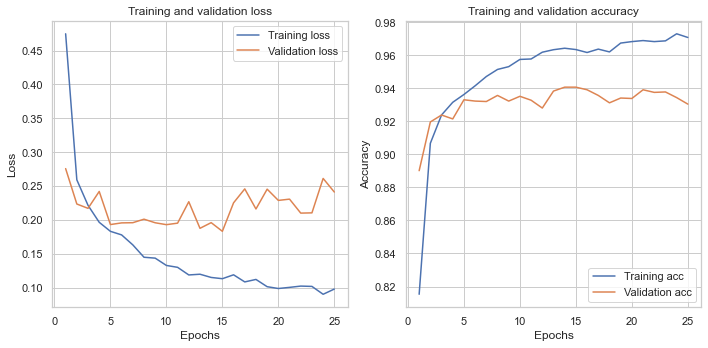

[[2392    0  170]
 [   0   93    0]
 [  91    2  907]]
[[0.93364559 0.         0.06635441]
 [0.         1.         0.        ]
 [0.091      0.002      0.907     ]]


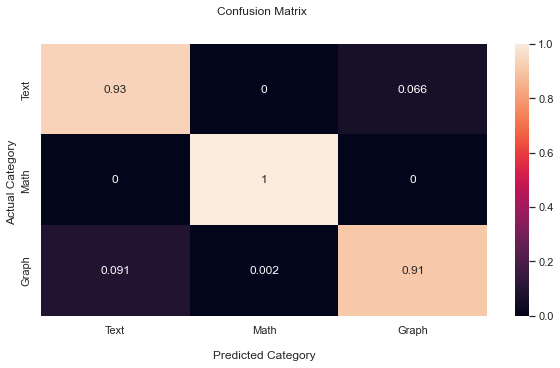

In [9]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=128,
    num_heads=5, #2,5
    ff_dim=4, # Hidden layer size in feed forward network inside transformer
    num_transformer_blocks=4,
    mlp_units=[128], #128
    n_classes=3,
    mlp_dropout=0.2, #0.4,0.2
    dropout=0.1, #0.25,0.1
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    #validation_split=0.2,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32, #64, 32, 16, 8
    callbacks=callbacks,
)
history_dict = history.history
history_dict.keys()

# Evaluation
results = model.evaluate(x_test, y_test, verbose=1)
#print ("Accuracy on test set:" , results)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

# Visualization
visResultT(history)

# Confusion Matrix
visConfusionMatrix(model, x_test, y_test)